# Linear Regression: Engineering & Regularizaion
#### King Count Housing Data
* June 17, 2019
* Erika d'Auria, David Haase
* Flatiron School, NYC (mhtn-ds-042219)

## Project Description
## Import libraries and set up environment
* modeler.py (LinearModeler) is a home-made library

In [30]:
import pandas as pd
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.feature_selection import RFECV

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from modeler import LinearModeler

pd.set_option('display.max_columns', 300)

## Load Data

In [31]:
data_file = 'kc_housing_data_for_feat_engineering_lab.csv'

KC = LinearModeler()
KC.read_csv(data_file)

(21600, 24)

## Explore Data

In [32]:
# KC.missing_data()

In [33]:
# KC.explore_data()

In [34]:
# cols  = ['price_log', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
#          'grade', 'sqft_above','sqft_basement', 'yr_renovated', 
#        'sqft_living15', 'sqft_lot15', 'yr_old', 'since_sold']

# KC.plot_pairs(cols)

##### Decisions
* Convert date to time-date type
* There were no NaNs to deal with
* We should try taking logs of non-linear features: `sqft_living_log, sqft_above_log, sqft_living15_log, price_log`

In [35]:
KC.df['date'] = pd.to_datetime(KC.df['date'])
KC.df['sqft_living_log'] = np.log(KC.df['sqft_living'])
KC.df['sqft_above_log'] = np.log(KC.df['sqft_above'])
KC.df['sqft_living15_log'] = np.log(KC.df['sqft_living15'])
KC.df['price_log'] = np.log(KC.df['price'])

## Feature Engineering and Train/Test Split
* Seasons?
* Yard Size?
* Interaction Feature (living footage X lot footage)
##### Create Season Features

In [36]:
#Create dummy variables for season
seasons = ['Winter', 'Winter', 'Spring', 'Spring', 'Spring',\
           'Summer', 'Summer', 'Summer','Fall', 'Fall', 'Fall', 'Winter']

KC.df['season'] = KC.df['date'].map(lambda x: seasons[x.month-1] )
season_dummies = pd.get_dummies(KC.df['season'], prefix="season_", drop_first=True)
season_dummies['season__Spring'].replace(False, 0, inplace=True)
season_dummies['season__Summer'].replace(False, 0, inplace=True)
season_dummies['season__Winter'].replace(False, 0, inplace=True)

#Add the season dummy variables to the main dataframe
KC.df = pd.concat([KC.df, season_dummies], axis=1)

##### Create Yard Size

In [37]:
KC.df['sqft_yard_size'] = KC.df['sqft_lot'] - (KC.df['sqft_above']/KC.df['floors'])
KC.df['sqft_yard_size_log'] = np.log(KC.df['sqft_yard_size'])
KC.df = KC.df.dropna(subset=['sqft_yard_size_log'])

/Users/davidhaase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


##### Create Interaction term: living footage by lot footage

In [38]:
# Create 'sq_living_x_lot' colimun
KC.df['sq_living_x_lot'] = KC.df['sqft_living'] * KC.df['sqft_lot']
KC.df['sq_living_x_lot_log'] = np.log(KC.df['sq_living_x_lot'])


### Now set target and features and split

In [39]:
feature_columns = ['bedrooms', 'bathrooms', 'sqft_lot','floors', 'waterfront', 
 'view', 'condition', 'grade','sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long',
 'sqft_lot15', 'yr_old', 'since_sold','sqft_living_log', 
 'sqft_above_log', 'sqft_living15_log', 'season__Spring', 'season__Summer', 'season__Winter', 'sq_living_x_lot_log',
  'sq_living_x_lot',  'sqft_yard_size'  , 'sqft_yard_size_log'             ]

KC.set_target_and_features('price_log', feature_columns)
KC.split_data()

/Users/davidhaase/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/davidhaase/Documents/Flatiron/Lectures/Module_4/kc_feat_engineering_project_revamp/modeler.py:129: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  self.X_train =pd.DataFrame(data=scaler.transform(self.X_train), columns=self.features.columns)
/Users/davidhaase/Documents/Flatiron/Lectures/Module_4/kc_feat_engineering_project_revamp/modeler.py:130: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  self.X_test =pd.DataFrame(data=scaler.transform(self.X_test), columns=self.features.columns)


# Build Models
## Run initial baseline

Training set - Features:  (17276, 26) Target:  (17276,)
Test set - Features:  (4320, 26) Target:  (4320,)

TRAINING STATS
Training Intercept: 13.047389251015668
Training Coefficients:
[-2.30707377e-02  4.97316697e-02  2.66325587e+00  4.76334913e-02
  3.42295775e-02  4.87871570e-02  4.05337561e-02  1.86581795e-01
  2.13700420e-02  1.30381931e-02 -3.39721069e-02  1.89297995e-01
 -1.48571421e-02  7.66788401e-03  1.15750086e-01 -2.59406814e-02
  4.43527078e-02  1.77583605e-02  7.41231680e-02  2.50749681e-03
  1.92948839e-03 -1.31108129e-02  1.47033862e-01 -2.08023125e-02
 -2.61084948e+00 -1.63489230e-01]
Training R^2 Score: 0.7768380499547693
****
TRAINING ERRORS
Mean Absolute Error: 0.19081638917251786
Mean Squared Error: 0.06129323148418667
Root Mean Squared Error: 0.2475746987965181

By Deviation of Target

Mean Absolute Error (Z): 0.36437690360268815
Root Mean Squared Error (Z): 0.4727607651997008
****
TESTING ERRORS
Test R^2 Score: 0.7821635639408808
Mean Absolute Error:0.188410672104

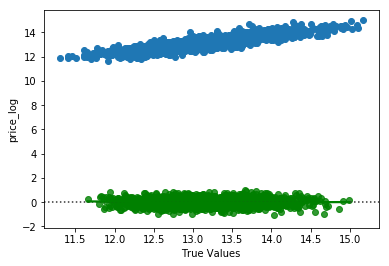

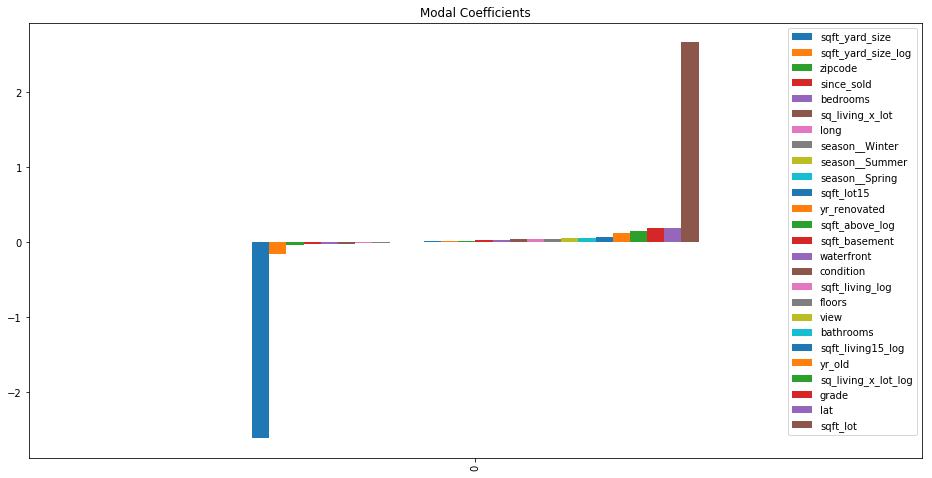

In [40]:
KC.evaluate_lm('Baseline')

## Drop Highly Correlated Features
* Highly correlated ( corr > 0.95):
* F-Test
* RFECV @ cv=20:

#### Removed
* sqft_yard_size
* sqft_lot
* waterfront
* condition
* sqft_basement
* yr_renovated'
* zipcode'
* long
* sqft_lot15
* yr_old
* since_sold'
* season__Spring
* season__Summer
* season__Winter'
* sq_living_x_lot'
* sqft_yard_size
* sqft_yard_size_log

In [41]:
drop_list = KC.get_drop_list_corrs()

for feature in KC.get_drop_list_f_test():
    drop_list.append(feature)

for feature in KC.get_drop_list_rfecv():
    drop_list.append(feature)

reduced_features = []
for feature in feature_columns:
    if feature not in drop_list:
        reduced_features.append(feature)


## Evaluate without Correlated Features

/Users/davidhaase/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/davidhaase/Documents/Flatiron/Lectures/Module_4/kc_feat_engineering_project_revamp/modeler.py:129: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  self.X_train =pd.DataFrame(data=scaler.transform(self.X_train), columns=self.features.columns)
/Users/davidhaase/Documents/Flatiron/Lectures/Module_4/kc_feat_engineering_project_revamp/modeler.py:130: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  self.X_test =pd.DataFrame(data=scaler.transform(self.X_test), columns=self.features.columns)


Training set - Features:  (17276, 10) Target:  (17276,)
Test set - Features:  (4320, 10) Target:  (4320,)

TRAINING STATS
Training Intercept: 13.047389251015666
Training Coefficients:
[-0.0156344   0.0111528  -0.00363021  0.08457192  0.1639522   0.20520546
  0.18120553 -0.01202953  0.05565388 -0.01279845]
Training R^2 Score: 0.7245037616712813
****
TRAINING ERRORS
Mean Absolute Error: 0.2133012247154025
Mean Squared Error: 0.07566726633049381
Root Mean Squared Error: 0.2750768371391779

By Deviation of Target

Mean Absolute Error (Z): 0.40731322992487157
Root Mean Squared Error (Z): 0.5252779732613783
****
TESTING ERRORS
Test R^2 Score: 0.7294281116836252
Mean Absolute Error:0.2100109096581754
Mean Squared Error:0.07372571438118325
Root Mean Squared Error:0.2715247951498781

By Deviation of Target

Mean Absolute Error (Z): 0.40103014901327455
Root Mean Squared Error (Z): 0.518495106930344

***
RMSE
Training:  0.2750768371391779 vs. Testing:  0.2715247951498781


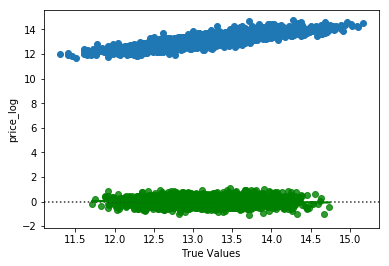

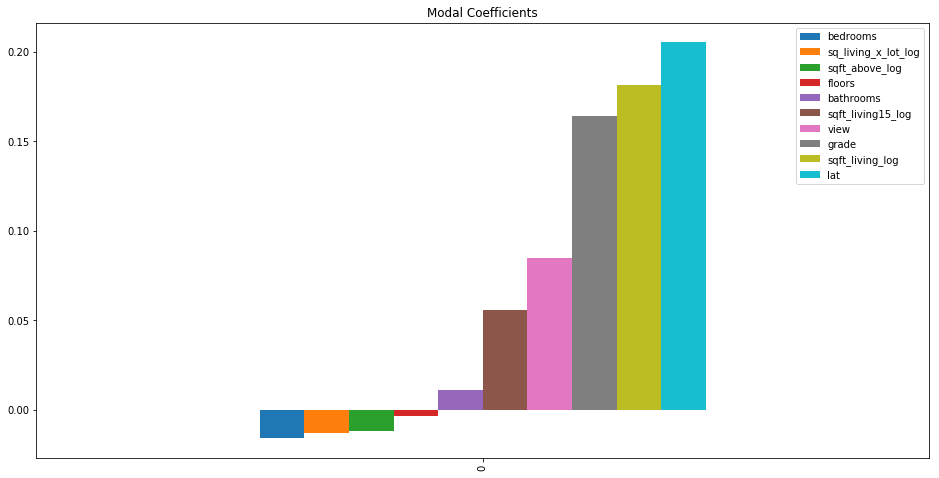

In [42]:
KC.set_target_and_features('price_log', reduced_features)
KC.split_data()
KC.evaluate_lm('Removed Corr')

## Evaluate LASSO

Training set - Features:  (17276, 10) Target:  (17276,)
Test set - Features:  (4320, 10) Target:  (4320,)

TRAINING STATS
Training Intercept: 13.047389251015664
Training Coefficients:
[0.         0.         0.         0.03573628 0.15650223 0.14543328
 0.13382402 0.         0.02880862 0.        ]
Training R^2 Score: 0.6821700935604298
****
TRAINING ERRORS
Mean Absolute Error: 0.23110364393715327
Mean Squared Error: 0.08729455009713608
Root Mean Squared Error: 0.295456511346655

By Deviation of Target

Mean Absolute Error (Z): 0.4413081630686583
Root Mean Squared Error (Z): 0.564194350498966
****
TESTING ERRORS
Test R^2 Score: 0.6881134944134324
Mean Absolute Error:0.22701464279160977
Mean Squared Error:0.08498316500394924
Root Mean Squared Error:0.29151872153251024

By Deviation of Target

Mean Absolute Error (Z): 0.433499936622795
Root Mean Squared Error (Z): 0.5566748723989008

***
RMSE
Training:  0.295456511346655 vs. Testing:  0.29151872153251024


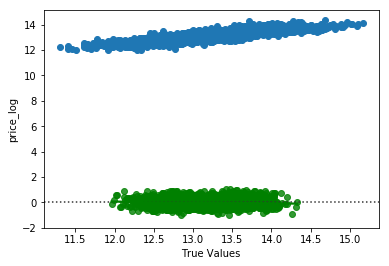

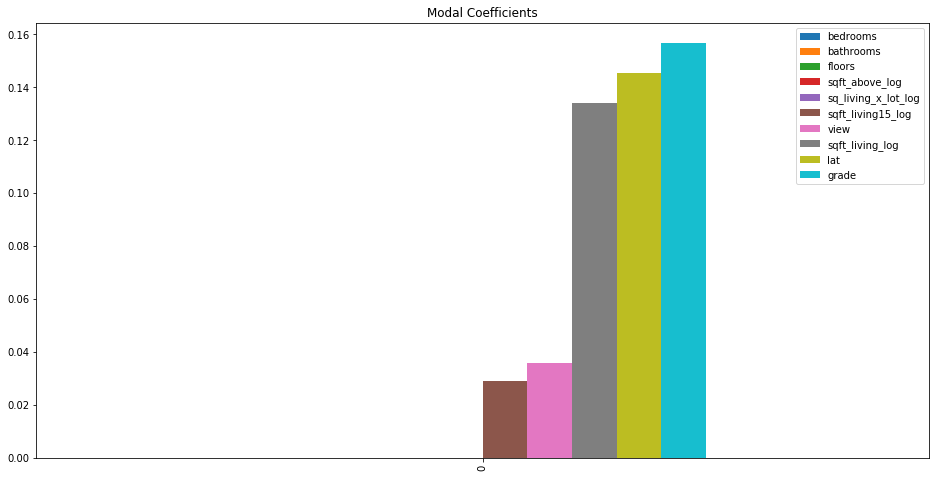

In [43]:
KC.evaluate_lasso(.0005)

## Evaluate Polynomial (2-degree) Model

Training set - Features:  (17276, 66) Target:  (17276,)
Test set - Features:  (4320, 66) Target:  (4320,)

TRAINING STATS
Training Intercept: 13.047389251022098
Training Coefficients:
[ 2.24344840e-13 -3.24326850e+00  6.31752739e+00  2.99306194e+00
 -4.24955125e-01 -9.77781233e+00  5.30677551e+01 -1.70875764e+01
  1.00741092e+01 -3.18599403e+00  2.54564570e+01  3.52772654e-02
 -5.39380271e-02  7.71550905e-02 -2.82863906e-02  8.87991794e-02
  3.17662080e+00 -4.30852826e-01  1.86819569e-01  3.13221301e-01
 -1.52702798e-01  2.59290391e-02 -1.66060490e-01  1.45137319e-03
  9.76774339e-02 -6.25729381e+00  2.30964722e-02  2.84262761e-01
 -6.18188558e-01  3.02580374e-01  4.69493468e-02 -7.58341049e-03
 -9.17092559e-02 -3.25987185e+00  1.28492057e+00 -8.02529255e-01
 -3.98923983e-01  2.28444755e-01  4.34918029e-02 -3.16340041e-02
  4.41816119e-01 -2.67398714e-01  2.47865594e-01  1.59186609e-01
 -6.86993329e-02 -5.47547093e-02  9.93738313e+00  1.67121624e-01
  5.60676379e-01 -4.18115716e-01 -2.

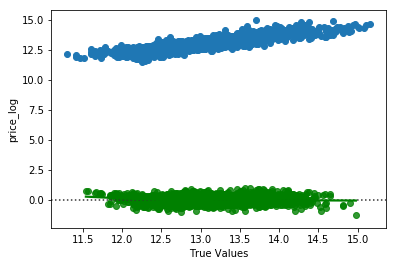

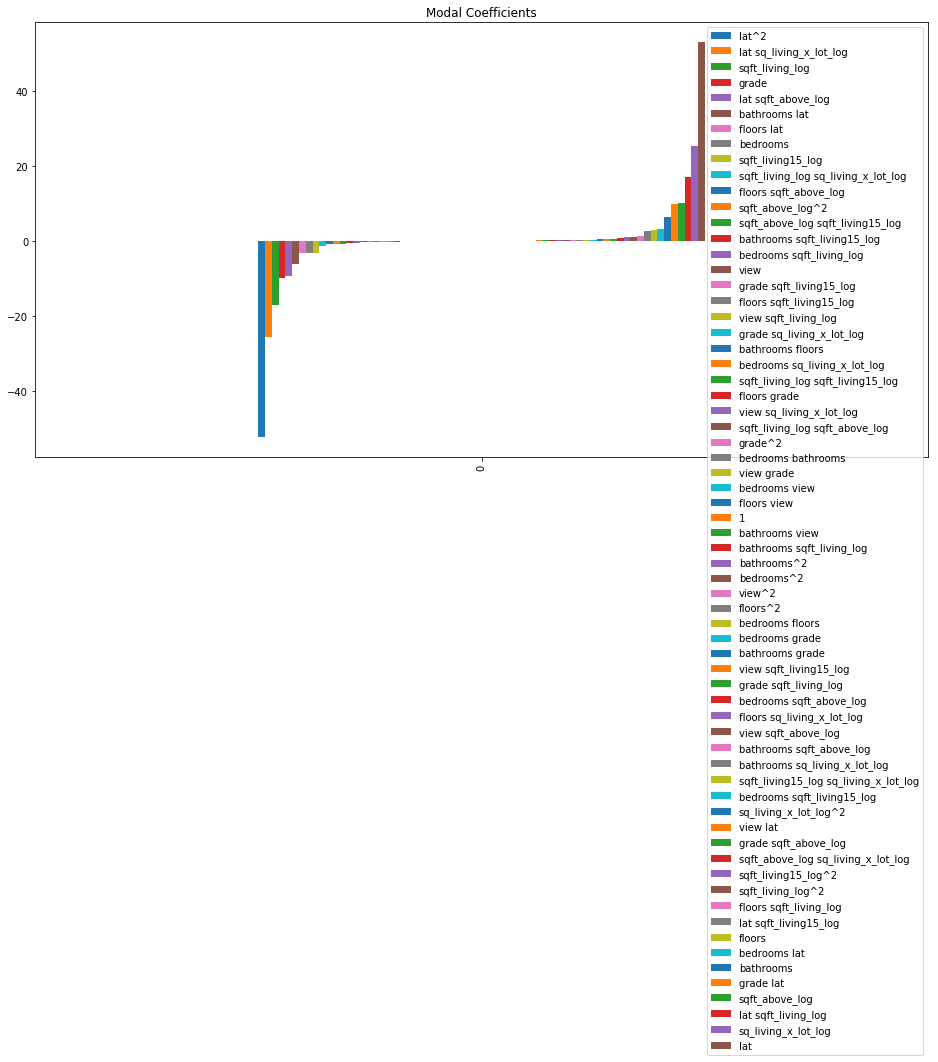

In [44]:
degree = 2
KC.set_polynomial(degree)

## Evaluate Polynomial (2-degree) + Ridge, alpha = 1.0

Training set - Features:  (17276, 66) Target:  (17276,)
Test set - Features:  (4320, 66) Target:  (4320,)

TRAINING STATS
Training Intercept: 13.047389251015643
Training Coefficients:
[ 0.         -0.00260905  0.00276216 -0.0012151   0.008667    0.02229538
  0.06973478  0.02038116  0.00233944  0.01274142 -0.00409806  0.00079309
  0.00338355  0.00046971  0.00497916  0.00984595 -0.00184031  0.0023093
 -0.00083586 -0.00033258 -0.00274577  0.00633578  0.00019578  0.00542607
  0.01151958  0.00329936  0.00631983  0.00372493  0.00385806  0.00306073
 -0.00175383  0.00684241  0.00738171 -0.00067954  0.00219092 -0.00049136
 -0.00025927 -0.00142094  0.00858296  0.00815978  0.00870762  0.00851102
  0.00835837  0.00867521  0.00814175  0.02312832  0.02354052  0.02362001
  0.01843748  0.02107862  0.01647819  0.06961604  0.02389246  0.00583589
  0.01731328 -0.00116488  0.02113807  0.01223154  0.01820359  0.00823978
  0.00300558  0.00729401 -0.00051357  0.01289795  0.00304479 -0.00311643]
Training R^2 

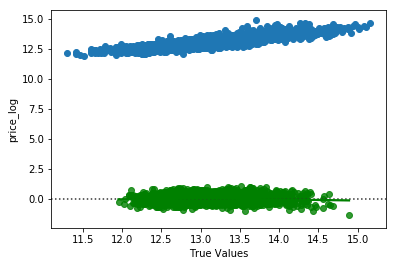

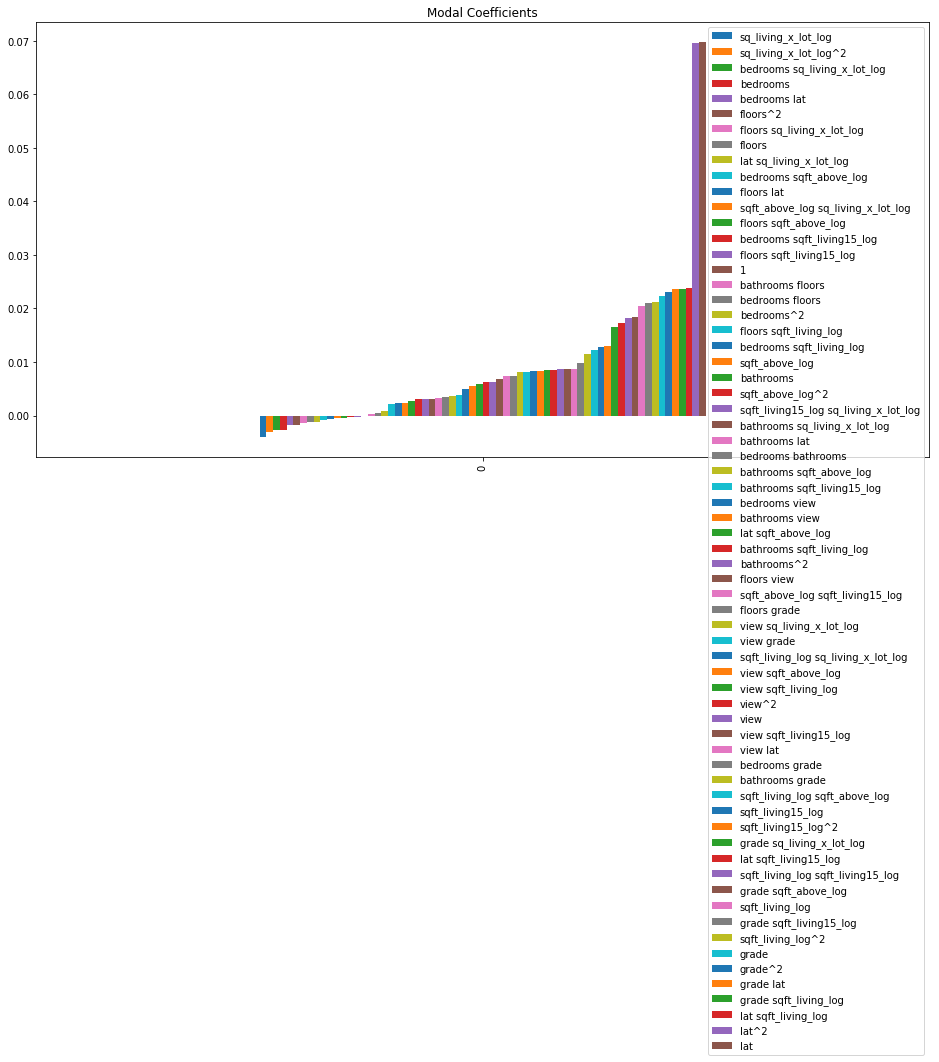

In [45]:
KC.evaluate_ridge(1.0)

## Reset Feature Columns

/Users/davidhaase/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/davidhaase/Documents/Flatiron/Lectures/Module_4/kc_feat_engineering_project_revamp/modeler.py:129: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  self.X_train =pd.DataFrame(data=scaler.transform(self.X_train), columns=self.features.columns)
/Users/davidhaase/Documents/Flatiron/Lectures/Module_4/kc_feat_engineering_project_revamp/modeler.py:130: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  self.X_test =pd.DataFrame(data=scaler.transform(self.X_test), columns=self.features.columns)


Training set - Features:  (17276, 10) Target:  (17276,)
Test set - Features:  (4320, 10) Target:  (4320,)

TRAINING STATS
Training Intercept: 13.047389251015666
Training Coefficients:
[-0.0156344   0.0111528  -0.00363021  0.08457192  0.1639522   0.20520546
  0.18120553 -0.01202953  0.05565388 -0.01279845]
Training R^2 Score: 0.7245037616712813
****
TRAINING ERRORS
Mean Absolute Error: 0.2133012247154025
Mean Squared Error: 0.07566726633049381
Root Mean Squared Error: 0.2750768371391779

By Deviation of Target

Mean Absolute Error (Z): 0.40731322992487157
Root Mean Squared Error (Z): 0.5252779732613783
****
TESTING ERRORS
Test R^2 Score: 0.7294281116836252
Mean Absolute Error:0.2100109096581754
Mean Squared Error:0.07372571438118325
Root Mean Squared Error:0.2715247951498781

By Deviation of Target

Mean Absolute Error (Z): 0.40103014901327455
Root Mean Squared Error (Z): 0.518495106930344

***
RMSE
Training:  0.2750768371391779 vs. Testing:  0.2715247951498781


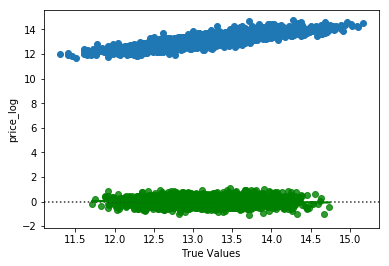

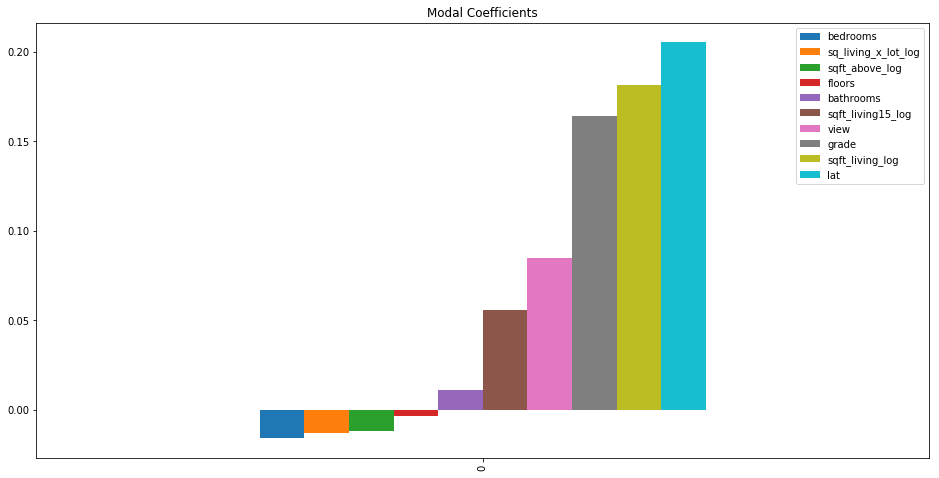

In [46]:
KC.set_target_and_features('price_log', reduced_features)
KC.split_data()
KC.evaluate_lm('Reset')

## Evaluate Ridge, alpha = 5.0

Training set - Features:  (17276, 10) Target:  (17276,)
Test set - Features:  (4320, 10) Target:  (4320,)

TRAINING STATS
Training Intercept: 13.04738925101566
Training Coefficients:
[0.01488433 0.02773081 0.01464721 0.02313925 0.04136775 0.03816874
 0.03634741 0.02860344 0.03309227 0.01656581]
Training R^2 Score: 0.43232972475616277
****
TRAINING ERRORS
Mean Absolute Error: 0.31460197321005323
Mean Squared Error: 0.1559152247063638
Root Mean Squared Error: 0.39486101948199925

By Deviation of Target

Mean Absolute Error (Z): 0.6007539151258872
Root Mean Squared Error (Z): 0.7540140354619682
****
TESTING ERRORS
Test R^2 Score: 0.43284682872513913
Mean Absolute Error:0.3123302972163069
Mean Squared Error:0.15453849613120418
Root Mean Squared Error:0.3931138462725578

By Deviation of Target

Mean Absolute Error (Z): 0.5964159949494316
Root Mean Squared Error (Z): 0.7506776891089395

***
RMSE
Training:  0.39486101948199925 vs. Testing:  0.3931138462725578


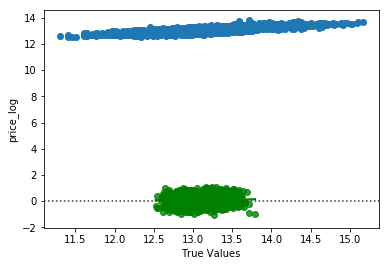

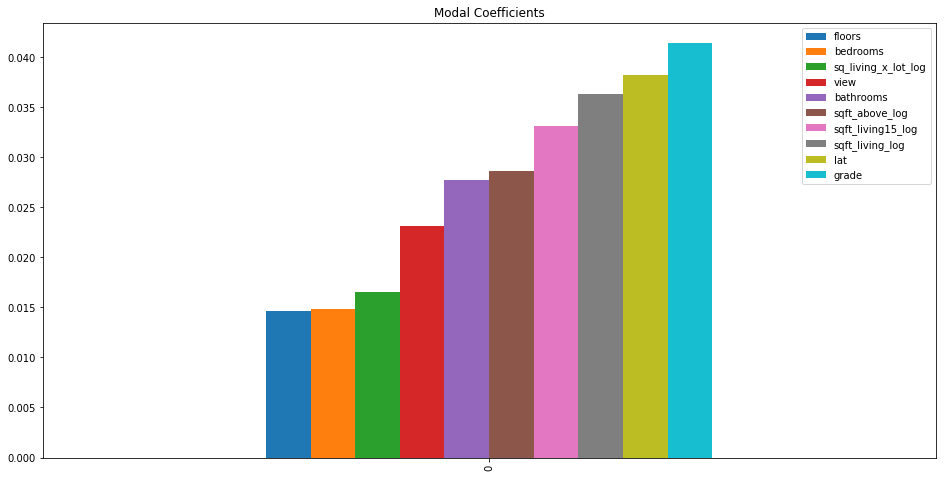

In [47]:
KC.evaluate_ridge(5.0)

## Evaluate Ridge, alpha = 0.01

Training set - Features:  (17276, 10) Target:  (17276,)
Test set - Features:  (4320, 10) Target:  (4320,)

TRAINING STATS
Training Intercept: 13.047389251015666
Training Coefficients:
[-0.01395688  0.01438695 -0.00432843  0.0845931   0.16170392  0.20405051
  0.17048876 -0.0054998   0.05683677 -0.01135144]
Training R^2 Score: 0.7244169814522938
****
TRAINING ERRORS
Mean Absolute Error: 0.2134594773966967
Mean Squared Error: 0.075691101218339
Root Mean Squared Error: 0.2751201577826296

By Deviation of Target

Mean Absolute Error (Z): 0.4076154242083232
Root Mean Squared Error (Z): 0.5253606969833367
****
TESTING ERRORS
Test R^2 Score: 0.7291869792579866
Mean Absolute Error:0.21019672547159543
Mean Squared Error:0.0737914183996284
Root Mean Squared Error:0.2716457590311846

By Deviation of Target

Mean Absolute Error (Z): 0.4013849769765749
Root Mean Squared Error (Z): 0.5187260957081391

***
RMSE
Training:  0.2751201577826296 vs. Testing:  0.2716457590311846


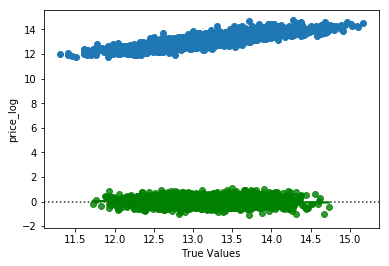

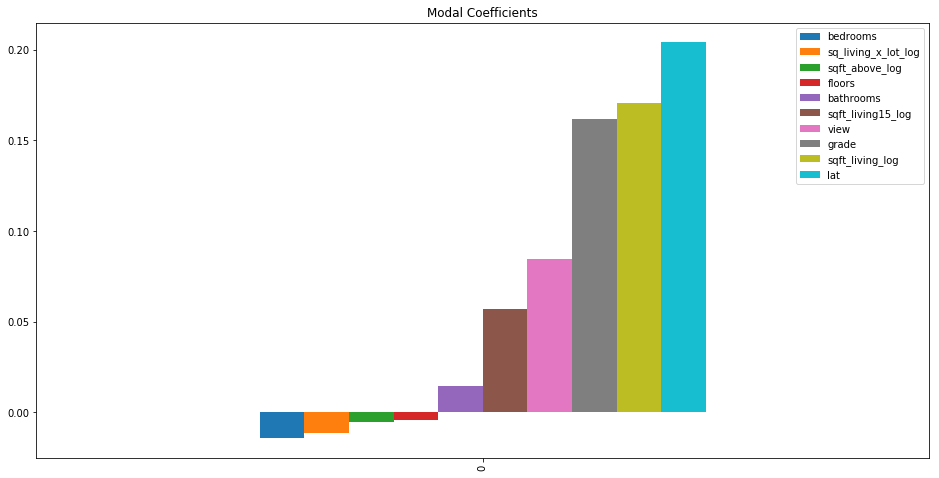

In [48]:
KC.evaluate_ridge(0.01)

## Evaluate Polynomial, 3-degress

Training set - Features:  (17276, 286) Target:  (17276,)
Test set - Features:  (4320, 286) Target:  (4320,)

TRAINING STATS
Training Intercept: 13.04738926855521
Training Coefficients:
[ 8.43573389e-07  6.12588972e+02 -4.43725913e+02  9.26813891e+02
 -1.04696864e+03 -1.84525207e+03 -3.52302737e+04  1.18226938e+02
 -6.85831579e+02 -1.70491494e+02  6.51877185e+02 -9.96609139e+00
  1.82905050e+00 -2.62962306e+01 -6.69427361e+00 -2.89079955e+01
 -1.22537940e+03  4.22901738e+01  1.29569646e+01  2.00483813e+01
 -2.78397816e+01 -1.52066630e+01  3.95390655e+01  1.84576782e+00
 -4.93169972e+00  9.20736369e+02  6.79887055e+00 -7.82701331e+01
  4.36647270e+01 -9.35967049e+00  4.54099239e+01  8.01032806e-01
 -5.02918332e+01 -1.87113704e+03 -2.76692326e+02  1.28169178e+02
  1.67527489e+02 -6.49326348e+00  2.03139717e+00  3.79598738e-01
  2.16283723e+03 -3.41736435e+01 -5.25992237e+01  1.30456898e+01
  4.28925159e+00  1.49831802e+00  3.59739936e+03  2.43225348e+02
  4.21746782e+01 -5.59795595e+01 -5

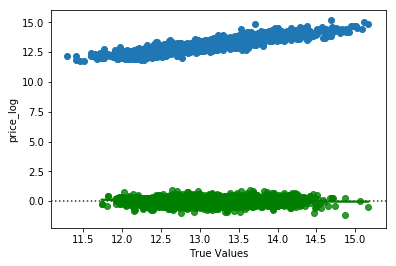

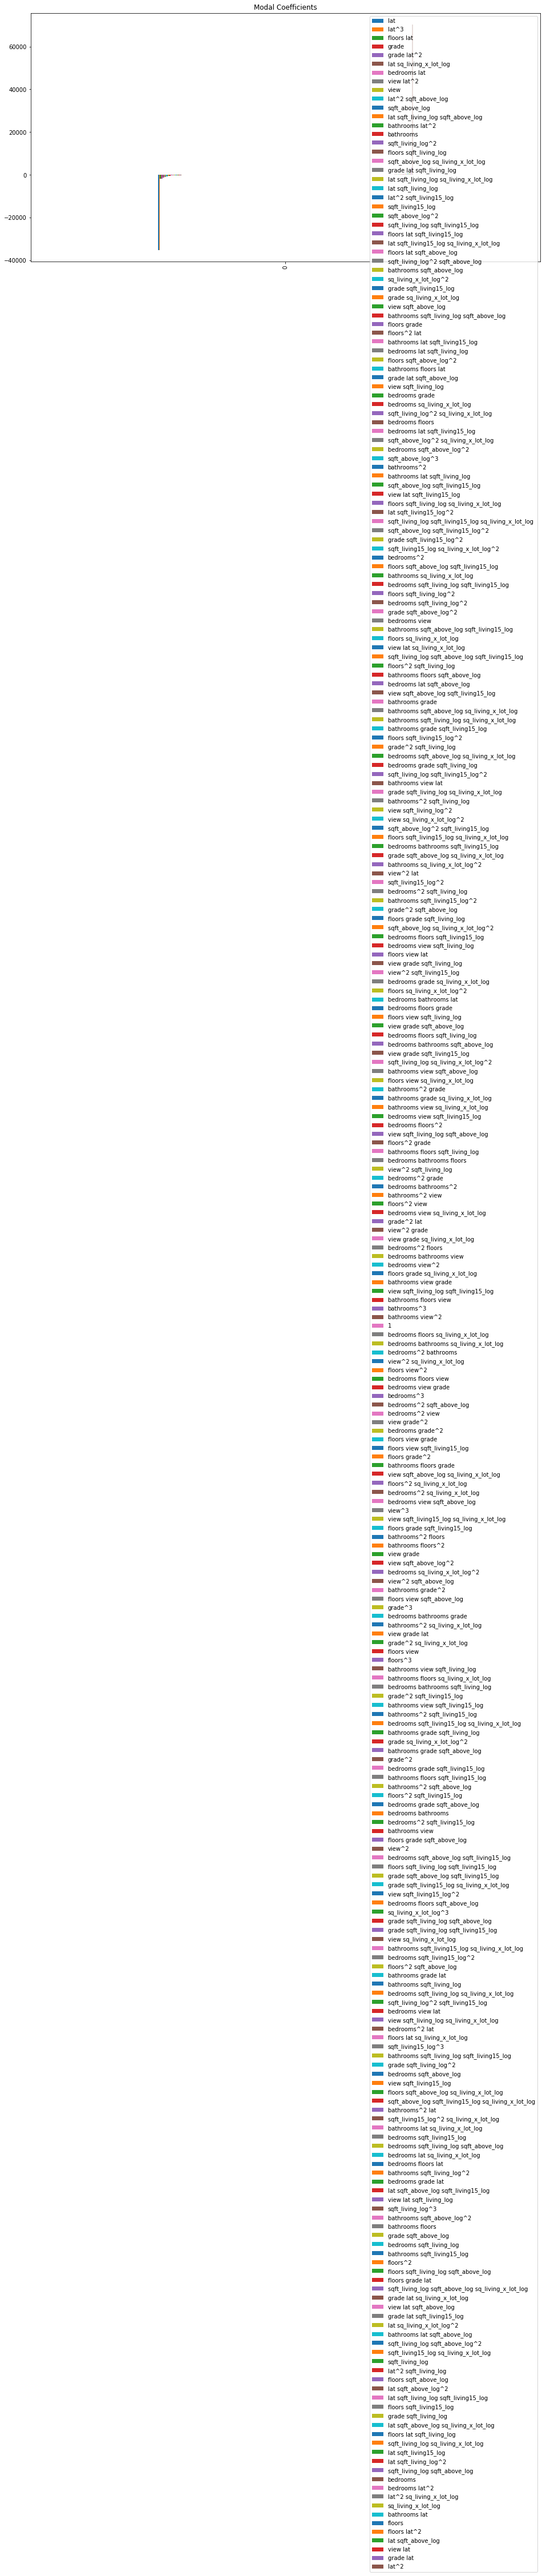

In [49]:
KC.set_target_and_features('price_log', reduced_features)
degree =3
KC.set_polynomial(degree)

Training set - Features:  (17276, 286) Target:  (17276,)
Test set - Features:  (4320, 286) Target:  (4320,)

TRAINING STATS
Training Intercept: 13.04738925101559
Training Coefficients:
[ 0.         -0.00783049 -0.00051217  0.0033868   0.00561108  0.02165262
  0.07584039  0.01448726 -0.00028752  0.01948711 -0.02747532  0.0033994
  0.00410625  0.02497238 -0.00220051  0.01321174 -0.00593099 -0.00238982
  0.0002491  -0.00579733 -0.02324782  0.02221308 -0.01645643  0.00929511
  0.01131309 -0.00096215  0.01515458  0.00222367 -0.02450817  0.00730947
 -0.01802858  0.00793502  0.00576794  0.00371624  0.029663   -0.00686961
 -0.02366227  0.01494496 -0.01179001 -0.00532124  0.0052036  -0.0025252
  0.00717216  0.00973665  0.01054622  0.01720237  0.02292474  0.02780129
  0.01151026  0.00107208 -0.01854687  0.06524001  0.0170972   0.00149613
  0.02257714 -0.03540077  0.02247542  0.01209679  0.0051572  -0.01918112
 -0.00380022 -0.0086954  -0.00580374  0.02772073 -0.01413402  0.03127596
 -0.00165118 -

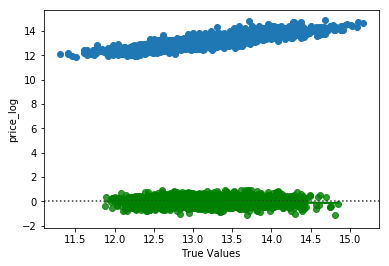

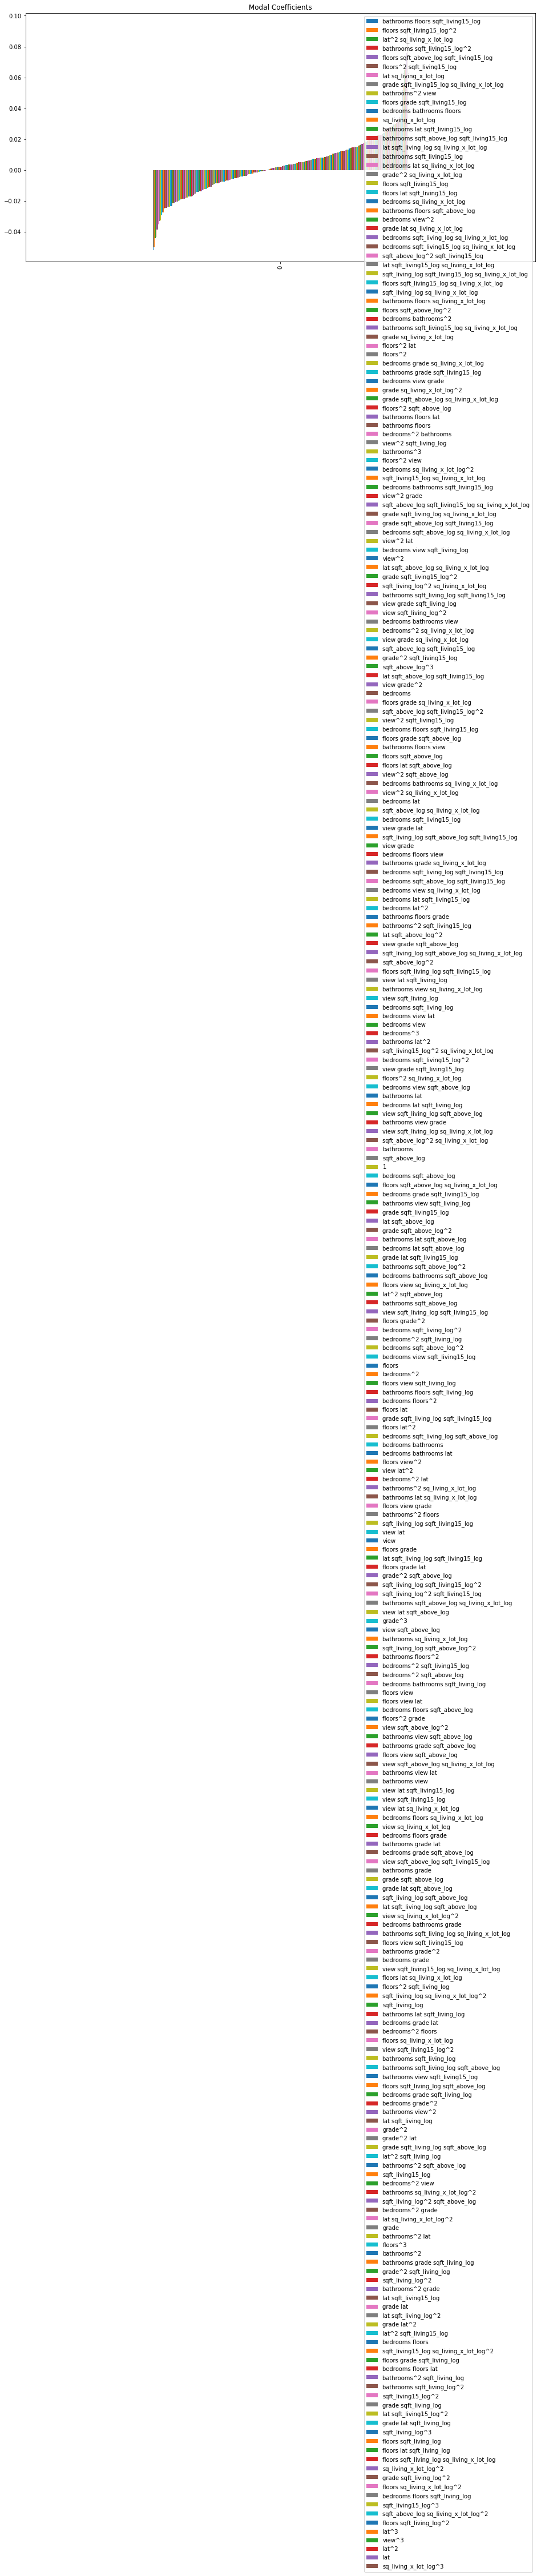

In [50]:
KC.evaluate_ridge(0.01)

# Plot Histories

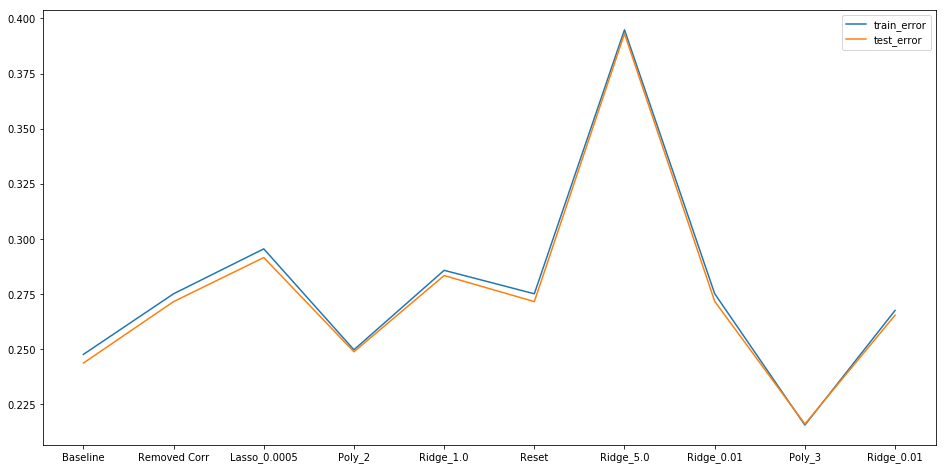

In [51]:
KC.plot_rmse_history()

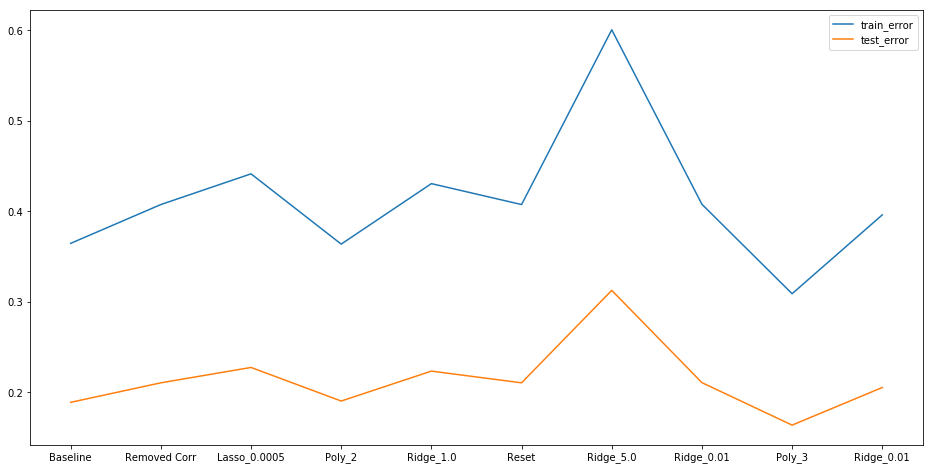

In [52]:
KC.plot_mae_history()


In [53]:
KC.find_lowest('Mean Absolute Error')

{'Training': {'result_type': 'Training Evaluation',
  'Training Intercept': 13.04738926855521,
  'Training Coefficients': array([ 8.43573389e-07,  6.12588972e+02, -4.43725913e+02,  9.26813891e+02,
         -1.04696864e+03, -1.84525207e+03, -3.52302737e+04,  1.18226938e+02,
         -6.85831579e+02, -1.70491494e+02,  6.51877185e+02, -9.96609139e+00,
          1.82905050e+00, -2.62962306e+01, -6.69427361e+00, -2.89079955e+01,
         -1.22537940e+03,  4.22901738e+01,  1.29569646e+01,  2.00483813e+01,
         -2.78397816e+01, -1.52066630e+01,  3.95390655e+01,  1.84576782e+00,
         -4.93169972e+00,  9.20736369e+02,  6.79887055e+00, -7.82701331e+01,
          4.36647270e+01, -9.35967049e+00,  4.54099239e+01,  8.01032806e-01,
         -5.02918332e+01, -1.87113704e+03, -2.76692326e+02,  1.28169178e+02,
          1.67527489e+02, -6.49326348e+00,  2.03139717e+00,  3.79598738e-01,
          2.16283723e+03, -3.41736435e+01, -5.25992237e+01,  1.30456898e+01,
          4.28925159e+00,  1.4983

In [54]:
KC.find_highest()

{'Training': {'result_type': 'Training Evaluation',
  'Training Intercept': 13.04738926855521,
  'Training Coefficients': array([ 8.43573389e-07,  6.12588972e+02, -4.43725913e+02,  9.26813891e+02,
         -1.04696864e+03, -1.84525207e+03, -3.52302737e+04,  1.18226938e+02,
         -6.85831579e+02, -1.70491494e+02,  6.51877185e+02, -9.96609139e+00,
          1.82905050e+00, -2.62962306e+01, -6.69427361e+00, -2.89079955e+01,
         -1.22537940e+03,  4.22901738e+01,  1.29569646e+01,  2.00483813e+01,
         -2.78397816e+01, -1.52066630e+01,  3.95390655e+01,  1.84576782e+00,
         -4.93169972e+00,  9.20736369e+02,  6.79887055e+00, -7.82701331e+01,
          4.36647270e+01, -9.35967049e+00,  4.54099239e+01,  8.01032806e-01,
         -5.02918332e+01, -1.87113704e+03, -2.76692326e+02,  1.28169178e+02,
          1.67527489e+02, -6.49326348e+00,  2.03139717e+00,  3.79598738e-01,
          2.16283723e+03, -3.41736435e+01, -5.25992237e+01,  1.30456898e+01,
          4.28925159e+00,  1.4983